# Implementation of Flow Matching


## Overview of the theory

"Flow Matching for Generative Modeling" paper (2023): https://arxiv.org/pdf/2210.02747

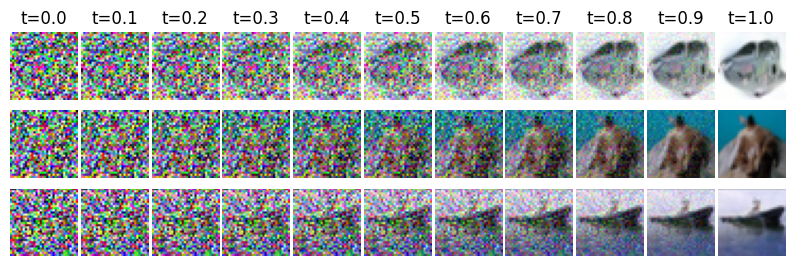

### **What is Flow Matching ?**

- **Recent generative modeling** method
- Generalizes the concepts of Diffusion/Score-based models
- Can be applied to any type of continuous input (images, videos, protein modeling...)
- Stable Diffusion 3.5 uses concepts of Flow matching

### **What is Generative Modeling?** 

It is the field of Machine Learning research, that tries to solve the following problem:

Given data samples $x_1, x_2,\dots,x_N$ from an unknown distribution $q$, **how to generate new samples following the distribution $q$** ?

### **In a nutshell, how does Flow Matching work?**

Goal: Find a function $\phi$
\begin{aligned}
    \phi_t \colon &[0,1] \times \mathbb{R}^d \to \mathbb{R}^d \\ 
    &(t,x) \mapsto \phi_t(x)
\end{aligned}

such that $x$ follows our base distribution (e.g. gaussian distribution)

and $\phi_1(x)$ follows our target distribution (e.g. natural images distribution)

**Examples**:

(Gaussian noise -> checkerboard)

![cifar10_sample_paths](misc/Fig4_sample_paths_checkerboard.png)

To find such a function $\phi$, we learn a **vector field** $v_t$ associated to $\phi$ through an ODE:

\begin{aligned}
    \frac{d}{dt}\phi_t(x) &= v_t(\phi_t(x)) \\
    \phi_0(x) &= x
\end{aligned}

**Visual Intuition**: the points of the base distribution start following the vector field $v_t$ at t=0. They arrive at the target distribution at time t=1


![learned_vf_checkerboard](misc/vf_checkerboard.png)

## Code

### Libraries

In [39]:
import numpy as np
from matplotlib import pyplot as plt
import torch as pt
from torch import nn, Tensor
from tqdm import tqdm

### Dataset

In [40]:
def create_2D_checkerboard_samples(n:int):

    # width of one cell
    width = 4
    locs = np.array([
        [0.0, 0.0],
        [8.0, 0.0],
        [12.0,4.0],
        [4.0, 4.0],
        [0.0, 8.0],
        [8.0, 8.0],
        [12.0,12.0],
        [4.0,12.0],
    ])
    # Randomly select one of the 8 locations as the label
    labels = np.random.choice(8, size=(n,), replace=True)
    # then add uniform noise
    samples = locs[labels] + np.random.uniform(0.0, 1.0, size=(n, 2)) * width

    return samples, labels

In [41]:
samples, labels = create_2D_checkerboard_samples(n=65536)

In [42]:
scaled_samples = ((samples - samples.mean(0)) / samples.std(0))

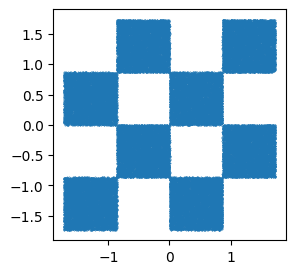

In [43]:
plt.figure(figsize=(3,3))
plt.scatter(scaled_samples[:,0], scaled_samples[:,1], s=.1)

# Model

In [3]:
class VectorField(nn.Module):

    def __init__(self, dim:int=2, hid_dim:int=64):
        super().__init__()
        self.MLP = nn.Sequential(
            nn.Linear(dim + 1, hid_dim), nn.GELU(),
            nn.Linear(hid_dim, hid_dim), nn.GELU(),
            nn.Linear(hid_dim, hid_dim), nn.GELU(),
            nn.Linear(hid_dim, dim)
        )
        
    def forward(self, x_t:Tensor, t:Tensor) -> Tensor:
        out = pt.cat((x_t, t), -1)
        out = self.MLP(out) 

        return out

### Initialization

In [24]:
device = pt.device("cuda")
vf = VectorField(2, 128).to(device)
# moving from numpy to tensor
samples = pt.tensor(scaled_samples, dtype=pt.float32, device=device)
optimizer = pt.optim.Adam(vf.parameters(), lr=1e-3)
epochs = 1000
batch_size = 2048
dim = 2
sigma_min = 0.001

In [25]:
print(sum(p.numel() for p in vf.parameters()))

33794


### Training

#### Optimal Transport variant

In [26]:
def Phi_cond_x1_OT(t:Tensor, x0:Tensor, x1:Tensor, sigma_min:float) -> Tensor:
    '''
    Optimal Transport Conditional Flow
    t: (B,), x: (B,d), x1: (B,d)

    Basically for very small sigma, (1.0-sigma)*t = t, therefore we get (1-t)*x0 + t*x1
    '''
    return (1.0 - (1.0 - sigma_min)*t)*x0 + t*x1

In [27]:
vf.train()
n_batches = samples.size(0) // batch_size
pbar = tqdm(range(1, epochs+1))
step = 0
loss_history = pt.zeros(size=(epochs,))

for epoch in pbar:
    
    for i in range(n_batches):
        
        # Sampling t ~ U[0,1] | x_0 ~ p_0 | x_1 ~ q (respectively time | noise | dataset samples)
        t = pt.rand(size=(batch_size, 1), device=device)# t ~ U[0,1] (B,1)
        x0 = pt.randn(size=(batch_size, dim), device=device) # x_0 ~ p_0 (B,d)
        x1 = samples[pt.randint(0, samples.size(0), size=(batch_size,))] # x_1 ~ q (B,d)
        # Interpolation of x0 to x1 at time t
        x_t = Phi_cond_x1_OT(t, x0, x1, sigma_min=sigma_min) # x_t ~ p_t (B,d)

        # Model prediction
        predicted_vector_field = vf(x_t, t)
        # Target x1-x0
        true_vector_field = x1 - (1.0 - sigma_min)*x0

        # MSE Loss
        loss = ((predicted_vector_field - true_vector_field) ** 2).mean()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        pbar.set_description_str(f"Epoch {epoch} | Step {step+i} | Loss: {loss.item():8f}")
    
    loss_history[epoch-1] = loss.item()
    step += i

Epoch 1000 | Step 31000 | Loss: 1.464757: 100%|██████████| 1000/1000 [01:41<00:00,  9.85it/s]


In [38]:
pt.save(vf, "models/checkerboard_VF_uncond.pt")

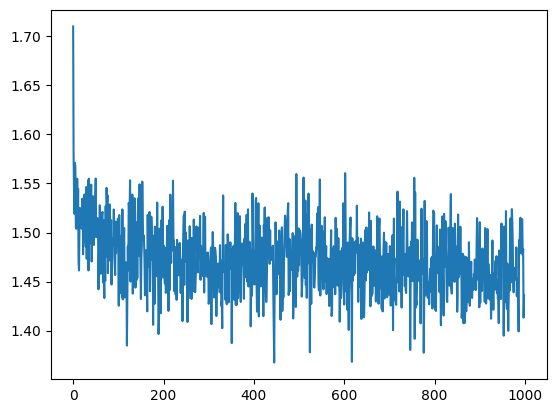

In [28]:
plt.plot(loss_history[:epoch-1])

# Visualisation

In [44]:
vf = pt.load("models/checkerboard_VF_uncond.pt")
vf.eval().cpu();

C:\Users\huang\AppData\Local\Temp\ipykernel_98048\2235804314.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vf = pt.load("models/checkerboard_VF_uncond.pt")


In [45]:
@pt.no_grad()
def learned_vf(x:Tensor, t:Tensor):
    return vf.forward(x, t)

### Visualisation of the vector field

In [46]:
def plot_vector_field_at_time_t(t:float, vector_field_fn:nn.Module, lim=4, figsize=(8,8), **plt_kwargs):
    assert 0.0 <= t <= 1.0, "t must be in the range [0,1]"

    # Creating grid points in R^2 plane
    x, y = pt.meshgrid(pt.arange(-lim, lim+1), pt.arange(-lim, lim+1), indexing="ij")
    grid_points = pt.stack([x.flatten(), y.flatten()], dim=1).to(pt.float32)
    # time t converted to tensor
    t_tensor = pt.ones(size=(grid_points.size(0),1), dtype=pt.float32) * t
    
    #directions
    vectors = vector_field_fn(grid_points, t=t_tensor)

    # Separate into components for plotting
    u = vectors[:, 0].reshape(x.shape).numpy()
    v = vectors[:, 1].reshape(y.shape).numpy()
    # Plot the vector field
    plt.figure(figsize=figsize)
    plt.quiver(x.numpy(), y.numpy(), u, v, **plt_kwargs)
    plt.xticks(np.arange(-lim, lim+1))
    plt.yticks(np.arange(-lim, lim+1))
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(f"Vector Field at time t={t}")
    plt.grid(True)
    plt.show()

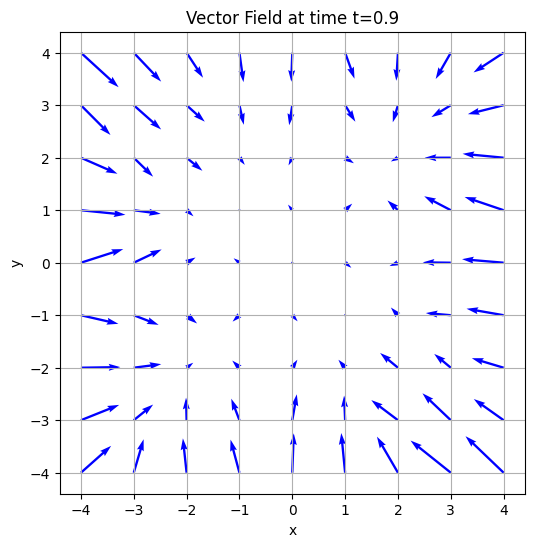

In [50]:
plot_vector_field_at_time_t(0.9, learned_vf, width=0.005, color="blue", figsize=(6,6), lim=4)

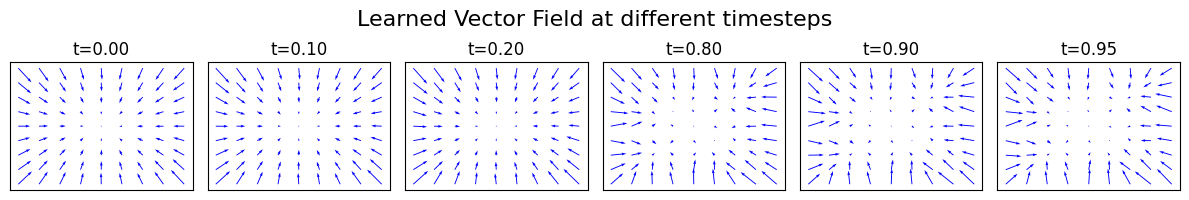

In [51]:
timesteps = [0.0, 0.10, 0.20, 0.80, 0.90, 0.95]
fig, axes = plt.subplots(1, len(timesteps), figsize=(12, 2))

for i, t in enumerate(timesteps):
    
    # Create grid points
    x, y = pt.meshgrid(pt.arange(-4, 5), pt.arange(-4, 5), indexing="ij")
    grid_points = pt.stack([x.flatten(), y.flatten()], dim=1).to(pt.float32)
    t_tensor = pt.ones(size=(grid_points.size(0), 1), dtype=pt.float32) * t
    
    # Compute the vector field
    vectors = learned_vf(grid_points, t=t_tensor)
    u = vectors[:, 0].reshape(x.shape).numpy()
    v = vectors[:, 1].reshape(y.shape).numpy()
    
    # Plot the vector field
    ax = axes[i]
    ax.quiver(x.numpy(), y.numpy(), u, v, width=0.005, color="blue")
    ax.set_title(f"t={t:.2f}")
    ax.set_xticks([])
    ax.set_yticks([])

# Adjust layout and show
plt.tight_layout(rect=[0, 0, 1, 0.90])
fig.suptitle("Learned Vector Field at different timesteps", fontsize=16)
plt.savefig("misc/vf_checkerboard.png")
plt.show()

# Sampling 

Solve the ODE to find the flow $\phi_t$ associated to the learned vector field $v_t$:

\begin{aligned}
    \frac{d}{dt}\phi_t(x) &= v_t(\phi_t(x)) \\
    \phi_0(x) &= x
\end{aligned}

In [57]:
from torchdiffeq import odeint

y0 = pt.randn(size=(4096,2))
t = pt.linspace(0, 1, 1000)

class ODE_VF(nn.Module):

    @pt.no_grad()
    def forward(self, t:Tensor, x:Tensor) -> Tensor:
        batch_size = x.size(0)
        t_expanded = t.expand(size=(batch_size, 1))

        return vf.forward(x, t_expanded)

The solution of the ODE is a tensor of shape (timesteps, number of samples, dimension).

The last timestep contains the generated samples.

In [58]:
solution = odeint(func=ODE_VF(), y0=y0, t=t, method='dopri5')
print(solution.shape)
generated_samples = solution[-1]

torch.Size([1000, 4096, 2])


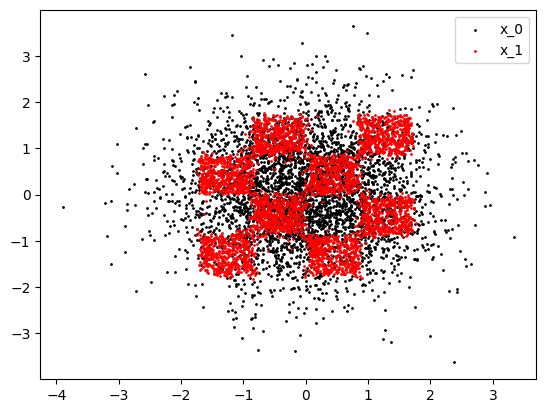

In [63]:
plt.scatter(y0[:,0], y0[:,1], label="x_0", color="black", s=1.0)
plt.scatter(generated_samples[:,0], generated_samples[:,1], label="x_1", color="red", s=1.0)
plt.legend()

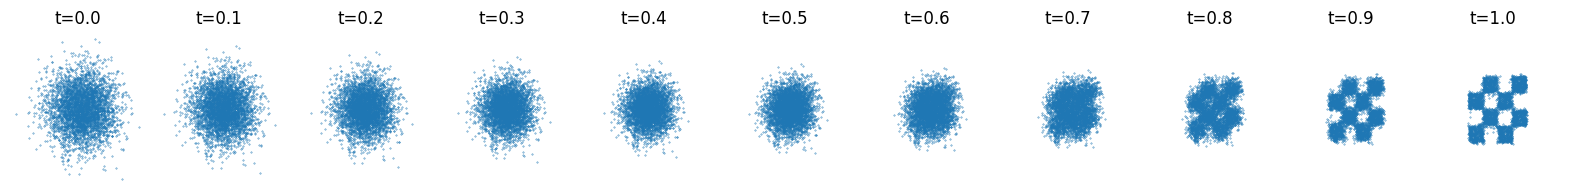

In [61]:
fig, axes = plt.subplots(1, 11, figsize=(20, 2.0), sharex=True, sharey=True)

time_steps = np.zeros(shape=(11,), dtype=np.int64)
time_steps[1:] = np.arange(99, 1000, 100, dtype=np.int64)
axes.flatten()

for t, time_step in enumerate(time_steps):
    axes[t].scatter(solution[time_step,:,0], solution[time_step,:,1], s=0.1)
    axes[t].axis("off")
    axes[t].set_title(f"t={round(time_step/1000, 2)}")

plt.subplots_adjust(wspace=0.05)
# fig.savefig("misc/Fig4_sample_paths_checkerboard.png", dpi=400)